# Noisy and Rotated Scanned Documents

<img src="https://i.stack.imgur.com/KAuwx.png"  width="600" >

## Problem Description
An insurance company is working on a system that can perform Optical Character
Recognition (OCR) on documents from their archives. Unfortunately, their documents have
been scanned at angles ranging from -5° to 5° from the horizontal. To increase OCR accuracy,
they need a preprocessing step that determines the angle of a given page so this distortion can
be corrected.

## Approach

The input of learning algorithm will be the scanned document images and the labels which are the different possible scanning angles. <br>

JSON data files provide a list of the scanned images which form the training and test sets separately. The algorithm will learn from the training set scanned document images and be validated on the test set images. The output of the learning algorithm will be the images labelled by their angles which have been predicted by the learning method. <br>

Labels have been provided, hence it is best to treat this a classification problem where the scanned pages are images that are labelled according to their scanned angle. With a training set consisting of images and their associated labels, a convolutional neural network (CNN) can be trained to recognise the angular rotation of new scanned images fed to it. This will form the preprocessing step needed to recognise the misalignment in scanned images in order to straighten them. <br>

The machine learning workflow designed for this is split into the three recommended stages: <br> 1. Ingestion <br> 2. Algorithm Design <br> 3. Reporting 

### 1. Data Ingestion

Import the necessary libraries for the workflow. 

In [1]:
# Helper libraries
import os
import numpy as np
import cv2
from PIL import Image
import json
from matplotlib import pyplot as plt
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

The scanned documents are loaded as images via the using the Python Imaging Library (PIL). Two examples are shown below.   


In [2]:
path = '../input/noisy-and-rotated-scanned-documents/scan_doc_rotation/'

['scan_000.png', 'scan_001.png', 'scan_002.png', 'scan_003.png', 'scan_004.png', 'scan_005.png', 'scan_006.png', 'scan_007.png', 'scan_008.png', 'scan_009.png']
Total number of images: 600


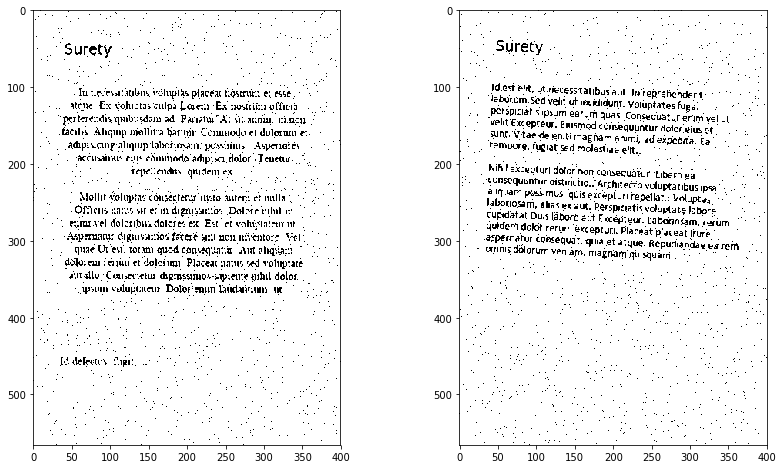

In [3]:
# Load and open images
names = [ file for file in os.listdir(path+'images/') ]
names = sorted(names)
N = len(names)

print(names[:10])

# Load two images to check
images = [Image.open(path+'images/'+names[i]) for i in range(2)]

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(images[0], cmap = 'gray')
plt.subplot(122),plt.imshow(images[1], cmap = 'gray')

print('Total number of images: %d'%N)

The images load correctly and there are 600 of them in total. Through trial and error, I realised that feeding these raw images into a CNN to train a model to find rotation angles of similar documents will be difficult because of difference between the texts contained within each document. The images need to be preprocessed to a simpler format which gives away only their rotation angle. Much credit is due to a user of Quora who provided <a href = "https://www.quora.com/How-do-I-detect-a-rotated-image-and-fix-it-back-to-its-proper-position-using-Python-OpenCV">this hint to perform a Fast Fourier Transform on the scanned image first.</a> This is one existing method for denoising an image and extracting frequency or amplitude from it which reveal the angular orientation [1]. An example of the FFT of one scanned document from the batch is shown below. 

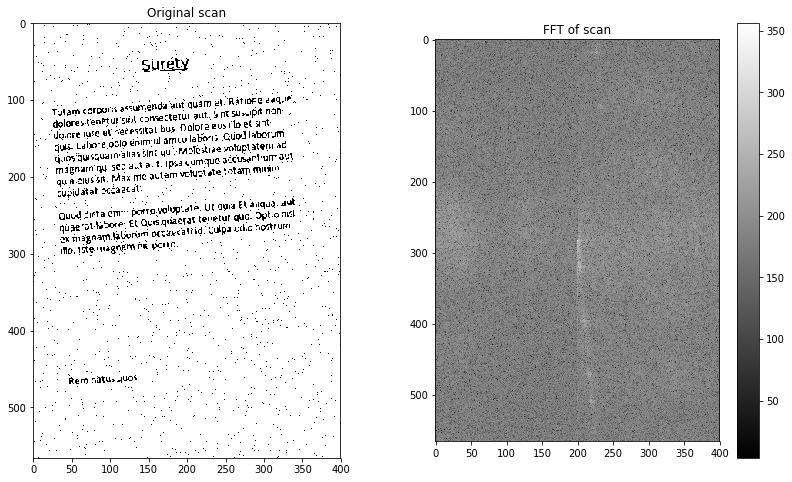

In [4]:
eg_img = path+'/images/'+names[18]
img = cv2.imread(eg_img)
img = img[:,:,0] #zeroth component is the red from RGB channel ordering
f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0 #shift to ensure no zeroes are present in image array
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))

plt.subplot(121),plt.imshow(img, 'gray')
plt.title('Original scan')

plt.subplot(122),plt.imshow(f_img, 'gray')
plt.title('FFT of scan')
plt.colorbar() 
plt.show()

The FFT does not provide clear orientation detail and this may be due to the noise - the little black dots scattered across the page. We can attempt to denoise the scanned page with a filter from the scikit image library and get a FFT of the denoised image to find its orientation. 

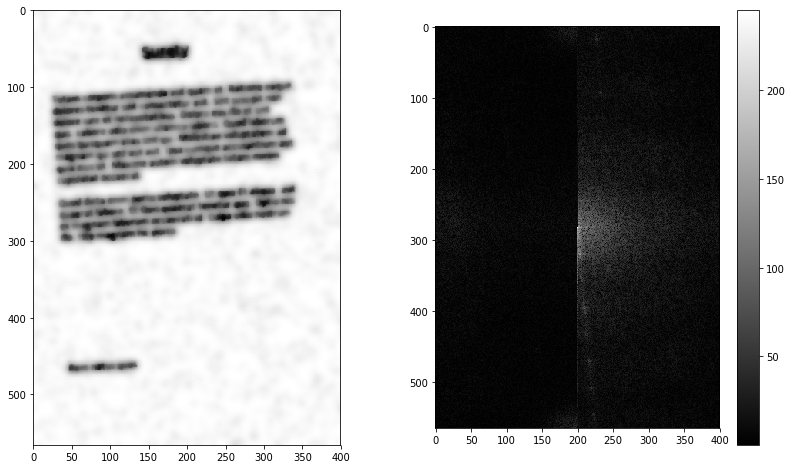

In [5]:
from skimage.restoration import denoise_tv_chambolle

img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
                               
f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(img, 'gray')
plt.subplot(122),plt.imshow(f_img, 'gray')
os.system('mkdir -p ./processed')
cv2.imwrite(path+'/processed/'+names[18], f_img)
plt.colorbar() 
plt.show()

There appears to be a bit of angular detail implicit in the FFT image of the original scanned document in this step. I will go ahead and process the rest of the images in this way. There may be better denoising methods for this case and, ideally, I would spend some more time finding the optimal denoising method that would provide the clearest angle definition in the FFT. 

In [6]:
fft_images = []
for i in range(N):
    img = cv2.imread(path+'/images/'+names[i])
    img = img[:,:,0]
    img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
    f = cv2.dft(np.float32(img))
    fshift = np.fft.fftshift(f)
    f_abs = np.abs(fshift) + 1.0 # shift to avoid np.log(0) = nan
    f_img = 20 * np.log(f_abs)
    fft_images.append( f_img )
    cv2.imwrite(path+'/processed/'+names[i], f_img)

We load the labels as integers to simplify the classification. This means that the angles, $\theta,$ will be classed as $\theta \in [-5,5]^{\circ}$ for $\theta \in \mathbb{Z}$ and that will give is 9 classes in total with which the CNN can classify new images.<br>
Note: I have set the negative angles to denote angular rotations below the horizontal (text tilted to the left) and positive angles above the horizontal (text titled to the right). 

In [7]:
# Load and open labels
label_names = [ file for file in os.listdir(path+'./labels') ]
label_names = sorted(label_names)
M = len(label_names)

print(label_names[:10])

labels = [ np.loadtxt(path+'./labels/'+label_names[j])
for j in range(M) ]
labels = [ round(float(labels[j])) for j in range(M) ]

# Load first 10 labels
[print(labels[i]) for i in range(10)]
print('Total number of labels %d'%len(labels))

['scan_000.txt', 'scan_001.txt', 'scan_002.txt', 'scan_003.txt', 'scan_004.txt', 'scan_005.txt', 'scan_006.txt', 'scan_007.txt', 'scan_008.txt', 'scan_009.txt']
0
-2
-5
-5
-1
-1
4
0
-5
-2
Total number of labels 500


There are 500 labels in total for the 500 training set images. That works out since this is supervised learning. 
The list of training and test set images have been provided in JSON data objects. 

In [8]:
# Deserialize JSON data lists for training and test sets
with open(path+'train_list.json') as train_data:
    train = json.load(train_data)
    
train_size = len(train)
print('Training set size: %d'%train_size)

with open(path+'test_list.json') as test_data:
    test = json.load(test_data)
    
test_size = len(test)
print('Test set size: %d'%test_size)

Training set size: 500
Test set size: 100


From the image and label data, it is clear that 500 images have known rotations and 100 do not which makes sense in light of the sizes of the training and test sets read from the JSON data files. 

### 2. Algorithm Selection
To recap, given that the training set data is labelled, this learning method will behave as a classifier and will train on the scanned images that have labelled angular rotations. The aim is to use the labelled data to select train an algorithm to correctly predict the angular rotations of 100 images in the test set as well as other scanned document images of a similar nature. 

The following is done in the next steps:<br>
$\bullet$ Converted the FFT images into arrays <br>
$\bullet$ Stack them into a batch of test and training data <br>
$\bullet$ Reshape the images to tensors <br>

In [9]:
# Get images into tensor form
image_arr = [ tf.keras.preprocessing.image.img_to_array(fft_images[i]) 
for i in range(N) ]

# get pixel dimensions of image
img_height = image_arr[0].shape[0]
img_width = image_arr[0].shape[1]

# Training and test image stacks
X_train = tf.stack(image_arr[:train_size], axis=0, name='train_set')
X_test = tf.stack(image_arr[-test_size:], axis=0, name='test_set')

pixel_count = img_height * img_width

# Reshape to 3D Tensor
X_train = np.array(X_train).reshape(train_size, pixel_count)
X_test = np.array(X_test).reshape(test_size, pixel_count)

# Normalise pixel values
X_train /= 255
X_test /= 255

# Training labels
Y_train_ = np.array(labels).reshape(len(labels))

# Check shape of each tensor
print(X_train.shape, Y_train_.shape)
print(X_test.shape)

(500, 226400) (500,)
(100, 226400)


In [10]:
# Show number of unique labels
classes = np.unique(Y_train_)
print(classes)
n_classes = len(np.unique(Y_train_))

# Create classes from unique labels
Y_train = to_categorical(Y_train_, n_classes)
print(Y_train.shape)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
(500, 11)


The images are shaped in the standard TensorFlow way for inputs: <br> (batch_size, img_height, img_width). The training images and their corresponding labels are loaded as X_train and Y_train, respectively. <br>
The goal is to feed these into the input layer of the CNN and train the model. If trained well, the model should make accurate predictions for the scanned angles of unlabelled document scans. <br>
I have borrowed the architecture of the hand-written digits CNN classifier for this problem. Below the model is instantiated and four convolutional layers between the input and output layers. There are 512 nodes in the input and hidden layers. In the output layer, 9 nodes represent each of the 9 classes for the angle prediction. 

In [11]:
model = Sequential()

model.add(Dense(512, activation='relu', 
                 input_shape=(pixel_count,)))

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(n_classes, activation = 'softmax'))

In [12]:
model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'] )

In [13]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=2)

Train on 500 samples
Epoch 1/25
500/500 - 8s - loss: 4.1103 - accuracy: 0.0960
Epoch 2/25
500/500 - 7s - loss: 2.5708 - accuracy: 0.1020
Epoch 3/25
500/500 - 7s - loss: 2.4458 - accuracy: 0.0920
Epoch 4/25
500/500 - 7s - loss: 2.4133 - accuracy: 0.0980
Epoch 5/25
500/500 - 7s - loss: 2.3589 - accuracy: 0.1400
Epoch 6/25
500/500 - 7s - loss: 2.2537 - accuracy: 0.1900
Epoch 7/25
500/500 - 7s - loss: 2.0770 - accuracy: 0.2080
Epoch 8/25
500/500 - 7s - loss: 1.5802 - accuracy: 0.3340
Epoch 9/25
500/500 - 7s - loss: 1.4103 - accuracy: 0.4020
Epoch 10/25
500/500 - 7s - loss: 1.3441 - accuracy: 0.4240
Epoch 11/25
500/500 - 7s - loss: 1.2004 - accuracy: 0.4760
Epoch 12/25
500/500 - 7s - loss: 0.9393 - accuracy: 0.6040
Epoch 13/25
500/500 - 7s - loss: 0.8441 - accuracy: 0.6620
Epoch 14/25
500/500 - 7s - loss: 0.4296 - accuracy: 0.8240
Epoch 15/25
500/500 - 7s - loss: 1.0272 - accuracy: 0.6480
Epoch 16/25
500/500 - 7s - loss: 0.3736 - accuracy: 0.8860
Epoch 17/25
500/500 - 7s - loss: 0.3641 - ac

### 3. Reporting

The model is trained and can make predictions on the angular rotation of scanned documents that it is given. I begin, of course, with the 100 scanned images in the test set. 

In [14]:
predictions = model.predict_classes(X_test)
print(predictions)

[ 6 10  0  6 10  6  4  1  1 10  9  2  0  0 10  5  3  1  0  9  6  9  9  4
  0  4  1  4  6 10 10  6 10  3  6  0  3  1  9  8 10  2 10  5  4  9  0  4
  3  1  9  8  9  3  9  1  9  0  8  8  9  8  3  3  5  2 10  1  6  6  3  1
  1  3  9  6  4  9  1  4  0  8  5  8  2 10  1 10  9  4 10  6  8  1  5  9
  1  9  9  3]


The numbers represent the indices of the classes labelled from $-5$ to $5^\circ.$ The first 10 predictions are shown in the dataframe below. 

In the interest of quantifying performance, the accuracy and loss are shown as a function of training iterations. 

In [15]:
df = pd.DataFrame({'Image name': names[-test_size:], 'Rotated angle (deg)': classes[predictions]})
df.head(10)

,Image name,Rotated angle (deg)
0,scan_500.png,1
1,scan_501.png,5
2,scan_502.png,-5
3,scan_503.png,1
4,scan_504.png,5
5,scan_505.png,1
6,scan_506.png,-1
7,scan_507.png,-4
8,scan_508.png,-4
9,scan_509.png,5


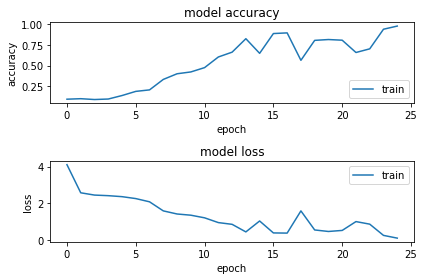

In [16]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

This kernel was loads of fun to write and I am happy with the result. 
Looking forward to seeing what other interesting things can be done with this dataset. 

### References:
[1] https://www.tensorflow.org/api_docs/python/tf/keras <br>
[2] https://github.com/d4nst/RotNet <br>
[3] https://timdettmers.com/2015/03/26/convolution-deep-learning/#  <br>
[4] https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
